In [299]:
# import time
# start_time = time.time()
# thisset = set()
# for i in range(1000000):
#     thisset.add((0, 0))
print(1 << (1 << 0 - 1))

ValueError: negative shift count

In [1]:
from matplotlib import pyplot as plt
from random import randint
import time
import fileinput
import sys

TURN_LEFT, TURN_RIGHT, TURN_NONE = (1, -1, 0)


def turn(p, q, r):
    a = (q[0] - p[0])*(r[1] - p[1]) - (r[0] - p[0])*(q[1] - p[1])
    return (a > 0) - (a < 0)


def dist(p, q):
    return ((p[0] - q[0])**2 + (p[1] - q[1])**2)**0.5;


def add_hull_point(hull, r):
    # dokud nejedeme doleva odstraňuj elementy z hull
    while len(hull) > 1 and turn(hull[-2], hull[-1], r) != TURN_LEFT:
            hull.pop()
    # pokud tenhle bod neni ten první tak ho přidej
    if not len(hull) or hull[-1] != r:
        hull.append(r)
    return hull


def graham_scan(points):
    points.sort()
    right_hull = []
    left_hull = []
    for point1, point2 in zip(points, reversed(points)):
        right_hull = add_hull_point(right_hull, point1)
        left_hull = add_hull_point(left_hull, point2)
    return right_hull + left_hull[1:-1]


def min_hull_pt_pair(hulls):
    s = time.time()
    h, p = 0, 0
    for i in range(len(hulls)):
        j = min(range(len(hulls[i])), key=lambda l: hulls[i][l])
        if hulls[i][j] < hulls[h][p]:
            h, p = i, j
    print(time.time() - s)
    return (h, p)


def rtangent(hull, p):
    # tady byly ty srandy zase btw
    l, r = 0, len(hull)
    # zjistim, kam zatáčim když pujdu: bod v kterym jsem -> 1. bod pod-obalu -> další/předchozí bod pod-obalu
    l_prev = turn(p, hull[0], hull[-1])  # bod v ktery teď jsem, první bod v pod-obalu, poslední bod v pod-obalu
    l_next = turn(p, hull[0], hull[1 % r]) # bod v ktery teď jsem, první bod v pod-obalu, druhej bod v pod-obalu
    while l < r:
        c = (l + r) // 2
        c_prev = turn(p, hull[c], hull[(c - 1) % len(hull)])
        c_next = turn(p, hull[c], hull[(c + 1) % len(hull)])
        c_side = turn(p, hull[l], hull[c])
        if c_prev != TURN_RIGHT and c_next != TURN_RIGHT: # pokud ani předchozí, ani následující bod nejde doleva, tak ten na kterym jsem teď je optimální z celýho tohohle pod-obalu
            return c % len(hull)
        elif c_side == TURN_LEFT and (l_next == TURN_RIGHT or l_prev == l_next) or \
            (c_side == TURN_RIGHT and c_prev == TURN_RIGHT):
            r = c               # Tangent touches left chain
        else:
            l = c + 1           # Tangent touches right chain
            l_prev = -c_next
            l_next = turn(p, hull[l % len(hull)], hull[(l + 1) % len(hull)])
    return l % len(hull)


def next_hull_pt_pair(hulls, pair):
    p = hulls[pair[0]][pair[1]]
#                         když je index bodu v obalu větší než dýlka obalu ?? naaah
    next_p = (pair[0], (pair[1] + 1) % len(hulls[pair[0]]))
    #projede všechny pod-obaly, pokud v některym z nich je bod kterej jde víc doprava než ten další v pod-obalu ve kterym se nachází momentální bod, tak to je další bod
    for h in range(len(hulls)):
        if h != pair[0]:
            s = rtangent(hulls[h], p) # vrátí index nejlepšího dalšího bodu v pod-obalu i indexem h
            q, r = hulls[next_p[0]][next_p[1]], hulls[h][s]
#             print(p)
#             print("další bod v týhle hull: [" + str(q[0]) + ":" + str(q[1]) + "] ideální bod v další hull: [" + str(r[0]) + ":" + str(r[1]) + "]")
            t = turn(p, q, r)
            if t == TURN_RIGHT or (t == TURN_NONE and dist(p, r) > dist(p, q)):
                next_p = (h, s)
    return next_p


def hull(points):
    for t in range(len(points)):
        m = min(len(points), 1 << (1 << t))
        diameter = 0
        hulls = []
        i = 0
        while i < len(points):
            hulls.append(graham_scan(points[i:i + m]))
            i += m
        main_hull = [min_hull_pt_pair(hulls)]
#         print(m)
#             print(hulls)
        for a in range(m):
            p = next_hull_pt_pair(hulls, main_hull[-1])
#                 print(hulls[p[0]][p[1]])
            diameter += dist(hulls[main_hull[-1][0]][main_hull[-1][1]], hulls[p[0]][p[1]])
            if p == main_hull[0]:
                return "%.2f" % diameter
            main_hull.append(p)

               
def random_points(ct):
    return [[randint(0, 50), randint(0, 50)] for _ in range (ct)]


def plot_points(points, convex_hull=None):
    xs, ys = zip(*points)
    plt.scatter(xs, ys)
    
    if convex_hull!=None:
        for i in range(1,len(convex_hull)+1):
            if i==len(convex_hull): i=0 # wrap
            c0=convex_hull[i-1]
            c1=convex_hull[i]
            plt.plot((c0[0],c1[0]),(c0[1],c1[1]),'r')
    plt.show()

points = random_points(10000)
# points = [[-4, 3], [-3, 1], [-1, 1], [0, 3], [-2, 4], [-1, 2], [3, 2], [6, 2], [6, 6], [2, 5], [0,4], [0, 0], [1, -2], [1, 1]]
# print(points)

start_time = time.time()
hull, diameter = hull(points)
print(time.time()- start_time)

print(len(hull))
print(diameter)
plot_points(points, hull)

# neotestováno
# python paska.py paska_input.txt > vystup.txt
# if __name__ == "__main__":
#     unique_coordinates = set()
#     for line in fileinput.input():
#         if not fileinput.isfirstline():
#             numbers = line.split(" ", 1)[1]
#             it = iter(numbers)
#             unique_coordinates.update(zip(it, it)
#     sys.stdout.write(hull(unique_coordinates)[1] + "\n")

0.006997346878051758
0.003998279571533203
0.0009996891021728516
0.3478872776031494
5
199.41


<Figure size 640x480 with 1 Axes>

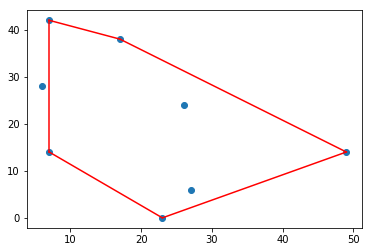

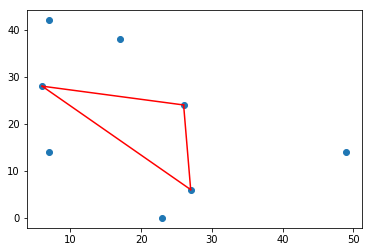

In [64]:
def plot_points(points, convex_hull=None):
    xs, ys = zip(*points)
    plt.scatter(xs, ys)
    
    if convex_hull!=None:
        for i in range(1,len(convex_hull)+1):
            if i==len(convex_hull): i=0 # wrap
            c0=convex_hull[i-1]
            c1=convex_hull[i]
            plt.plot((c0[0],c1[0]),(c0[1],c1[1]),'r')
    plt.show()

stuff = [[7, 14], [7, 42], [17, 38], [49, 14], [23, 0], [6, 28], [26, 24], [27, 6]]
plot_points(stuff,
            [[7, 14], [23, 0], [49, 14], [17, 38], [7, 42]])
plot_points(stuff,
            [[6, 28], [27, 6], [26, 24]])